In [91]:
import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
sys.path.append('../../src/')
# from diffusion import DiffusionModel
# from evaluate import get_results
from omegaconf import OmegaConf
# from main import load_data, make_model
import numpy as np
import os
import glob
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import torch
from model2 import Autoencoder, Preprocessor, WDiscriminator
from off_manifolder import offmanifolder_maker
import magic
import torch
import pathlib
import copy

import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
from omegaconf import OmegaConf
import os
import glob
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from geodesic import jacobian, velocity, CondCurve, GeodesicBridgeOverfit, GeodesicBridge
from plotly3d.plot import scatter, trajectories
import torch
from torch import nn
import pytorch_lightning as pl
from procrustes import Procrustes
from torch.utils.data import DataLoader, TensorDataset


import hydra
from omegaconf import DictConfig, OmegaConf
import wandb
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint


In [92]:
def _distance_to_geodesic_criterion(predicted_geodesic, true_geodesic):
    # the inputs here are single samples from a geodesic; should be shape num_samples x num_dims
    # for each input point, we want the closest distance to any point on the true geodesic using the euclidean distance, torch.cdist
    D = torch.cdist(predicted_geodesic, true_geodesic)
    min_dists_to_true_geodesic = D.min(dim=1)[0]
    # we take the mean of the squared distances
    return torch.mean(min_dists_to_true_geodesic**2)
# def distance_to_geodesic_criterion(
#     predicted_geodesic:torch.Tensor, # size num_geodesics x num_samples x num_dims
#     true_geodesic:torch.Tensor, # size num_geodesics num_samples x num_dims. But it's okay if the num_samples are different
#     ):
#     """
#     Mean of the squared distances from each predicted point to the closest point on the true geodesic
#     """
#     dists = []
#     for i in range(predicted_geodesic.shape[0]):
#         dists.append(_distance_to_geodesic_criterion(predicted_geodesic[i], true_geodesic[i]))
#     dists = torch.stack(dists)
#     return dists.mean()

def distance_to_geodesic_criterion_len(
    predicted_geodesic:torch.Tensor, # size num_geodesics x num_samples x num_dims
    true_geodesic:torch.Tensor, # size num_geodesics num_samples x num_dims. But it's okay if the num_samples are different
    lengths=1.,
    ):
    """
    Mean of the squared distances from each predicted point to the closest point on the true geodesic
    """
    dists = []
    # for i in range(predicted_geodesic.shape[0]):
    for i in range(len(predicted_geodesic)):
        dists.append(_distance_to_geodesic_criterion(predicted_geodesic[i], true_geodesic[i]))
    dists = torch.stack(dists)
    dists = dists / lengths
    return dists.mean()

def distances_to_geodesic(
    predicted_geodesic:torch.Tensor, # size num_geodesics x num_samples x num_dims
    true_geodesic:torch.Tensor, # size num_geodesics num_samples x num_dims. But it's okay if the num_samples are different
    ):
    """
    Mean of the squared distances from each predicted point to the closest point on the true geodesic
    """
    dists = []
    # for i in range(predicted_geodesic.shape[0]):
    for i in range(len(predicted_geodesic)):
        dists.append(_distance_to_geodesic_criterion(predicted_geodesic[i], true_geodesic[i]))
    dists = torch.stack(dists)
    return dists

In [93]:
cfg_main_ae_sweep_id = 'jtpxi61p'
cfg_main_disc_sweep_id = '5nidtly5'
cfg_main_data_name = 'hemisphere_none_0'
cfg_main_weights_cycle = 1.0
cfg_main_dimensions_latent = 3.

In [94]:
# results_path = f'results/{cfg_main.data_name}/{cfg_main.dimensions_latent}'
# pathlib.Path(results_path).mkdir(parents=True, exist_ok=True)

wandb.login()
api = wandb.Api()

entity = "xingzhis"
project = "dmae"
sweep_id = cfg_main_ae_sweep_id
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
# Initialize an empty list to store run data
runs_data = []

for run in sweep.runs:
    # Extract metrics and configs
    metrics = run.summary._json_dict
    configs = run.config
    
    # Combine metrics and configs, and add run ID
    combined_data = {**metrics, **configs, "run_id": run.id}
    
    # Append the combined data to the list
    runs_data.append(combined_data)

# Create a DataFrame from the runs data
df = pd.DataFrame(runs_data)

data_name = cfg_main_data_name
run_ids = df[(df['data.name'] == data_name) & (df['cfg/loss/weights/cycle'] == 1.) & (df['cfg/dimensions/latent'] == 3)]['run_id']
# run_ids = df[(df['data.name'] == data_name) & (df['loss.weights.cycle'] == cfg_main_weights_cycle) & (df['dimensions.latent'] == cfg_main_dimensions_latent)]['run_id']
# run_ids = df[(df['data.name'] == data_name) & (df['loss.weights.cycle'] == cfg_main_weights_cycle) & (df['dimensions.latent'] == cfg_main_dimensions_latent) & (df['cfg/loss/weights/reconstr']==0.01) & (df['cfg/loss/weights/dist']==77.4)]['run_id']
assert len(run_ids) == 1
run_id = run_ids.iloc[0]
run = api.run(f"{entity}/{project}/{run_id}")
# run = api.run(f"{entity}/{project}/{run_id}")
folder_path = '../../src/wandb/'
cfg = OmegaConf.create(run.config)
folder_list = glob.glob(f"{folder_path}*{run.id}*")
ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
ckpt_path = ckpt_files[0]
cfg.data.root = '../' + cfg.data.root
model = Autoencoder.load_from_checkpoint(ckpt_path)
data = np.load(f"{cfg.data.root}/{cfg.data.name}{cfg.data.filetype}", allow_pickle=True)
with torch.no_grad():
    model.eval()
    x = torch.tensor(data['data'], dtype=torch.float32, device=model.device)
    z = model.encoder(x)
    xh = model.decoder(z)
    zhh = model.encoder(xh)
zc = z.cpu().numpy()
# fig = scatter(zc, s=2, alpha=0.2, title='latent', filename=f'{results_path}/latent.html')
# wandb.log({"latent": wandb.Plotly(fig)})
# fig = scatter(zhh, s=2, alpha=0.2, title='latent_reembedd', filename=f'{results_path}/latent_reembedded.html')
# wandb.log({"latent_reembedded": wandb.Plotly(fig)})
# fig = scatter(x, s=2, alpha=0.2, title='data', filename=f'{results_path}/data.html')
# wandb.log({"data": wandb.Plotly(fig)})
# fig = scatter(xh, s=2, alpha=0.2, title='reconstruction', filename=f'{results_path}/reconstruction.html')
# wandb.log({"reconstruction": wandb.Plotly(fig)})

sweep_id = cfg_main_disc_sweep_id
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
# Initialize an empty list to store run data
runs_data = []

# Iterate through each run in the sweep
for run in sweep.runs:
    # Extract metrics and configs
    metrics = run.summary._json_dict
    configs = run.config
    
    # Combine metrics and configs, and add run ID
    combined_data = {**metrics, **configs, "run_id": run.id}
    
    # Append the combined data to the list
    runs_data.append(combined_data)

# Create a DataFrame from the runs data
df = pd.DataFrame(runs_data)
run_ids = df[(df['loss.weights.pos1'] == 1.)&(df['data.name']==data_name)][['run_id']]
assert len(run_ids) == 1
run_id = run_ids.iloc[0]
run = api.run(f"{entity}/{project}/{run_ids.iloc[0].values[0]}")
folder_path = '../../src/wandb/'
cfg = OmegaConf.create(run.config)
folder_list = glob.glob(f"{folder_path}*{run.id}*")
ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
ckpt_path = ckpt_files[0]
cfg.data.root = '../' + cfg.data.root
wd = WDiscriminator.load_from_checkpoint(ckpt_path)
data_ = np.load(f"{cfg.data.root}/{cfg.data.name}{cfg.data.filetype}", allow_pickle=True)
with torch.no_grad():
    wd.eval()
    x_disc = torch.tensor(data_['data'], dtype=torch.float32, device=wd.device)
    probab = wd(x_disc).flatten()
    z = model.encoder(x_disc)

# # title = f'{data_name} {noise_type} {noise_level} {dist_mask}'
# scatter(zc, data['mask_x'][data['is_train'].astype(bool)], s=2, alpha=0.2).show()
# scatter(zhh, data['mask_x'][data['is_train'].astype(bool)], s=2, alpha=0.2).show()
# scatter(x_disc, data['mask_x'][data['is_train'].astype(bool)], s=2, alpha=0.2, title=f'{data_name}: input').show()
# scatter(x_disc, probab, s=2, alpha=0.2, title=f'{data_name}: probability').show()#, filename='hsphere_disc_prob.html').show()
# scatter(x_disc, probab > 0.5, s=2, alpha=0.2, title=f'{data_name}: classification').show()

# title = f'[RECON] {title}'
# if savefolder is not None:
#     filename = f"{savefolder}/{title1}.html"
# scatter(xh, data['mask_x'][data['is_train'].astype(bool)], s=2, alpha=0.2).show()

max_prob = probab.max()


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning:

Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning:

Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.



In [95]:
xbatch = torch.tensor(data['start_points'], device=x.device, dtype=x.dtype)
xendbatch = torch.tensor(data['end_points'], device=x.device, dtype=x.dtype)
ids = torch.zeros((xbatch.shape[0],1), device=x.device, dtype=x.dtype)
dataset = TensorDataset(xbatch, xendbatch, ids)
dataloader = DataLoader(dataset, batch_size=len(z), shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
wd = wd.to(device)
# med = probab.quantile(1-data['mask_x'].mean()).to(device)
# discriminator = discriminator.to(device)
for param in model.encoder.parameters():
    param.requires_grad = False
for param in wd.parameters():
    param.requires_grad = False
enc_func = lambda x: model.encoder(x)
# disc_func = lambda x: wd(x).flatten()
# disc_func_pen = lambda x: 1 - (max_prob - disc_func(x))
# discriminator_func_for_grad = lambda x: wd(x)
# discriminator_func_for_grad = lambda x: discriminator.positive_proba(x).reshape(-1,1)
disc_func = lambda x: (wd(x).flatten()-probab.min())/(probab.max()-probab.min())
# disc_func = lambda x: (torch.clamp(wd(x).flatten(), max=med) - probab.min())/(med-probab.min())
# disc_func_pen = disc_func
# discriminator_func_for_grad = lambda x: (wd(x)-probab.min())/(probab.max()-probab.min())
ofm = offmanifolder_maker(enc_func, disc_func, disc_factor=1., max_prob=max_prob)


In [96]:
res_list = []

In [97]:
gbmodel = GeodesicBridgeOverfit(
    func=ofm,
    # func = enc_func,
    # discriminator_func=disc_func_pen,
    # discriminator_func_for_grad=discriminator_func_for_grad,
    input_dim=x.size(1), 
    hidden_dim=64, 
    scale_factor=1, 
    symmetric=True, 
    num_layers=3, 
    n_tsteps=100, 
    lr=1e-3, 
    weight_decay=1e-3,
    discriminator_weight=0.,
    discriminator_func_for_grad_weight=0.,
    id_dim=1,
    id_emb_dim=1,
    density_weight=0.,
    length_weight=1.,
)

# if cfg_main.use_wandb:
#     logger = WandbLogger()
#     checkpoint_dir = wandb.run.dir  # Use wandb's run directory for saving checkpoints

# else:
#     logger = TensorBoardLogger(save_dir=os.path.join(results_path))
#     checkpoint_dir = results_path  # Use a local directory for saving checkpoints


gbmodel.lr=1e-3
trainer = pl.Trainer(
    # logger=logger,
    max_epochs=400,
    log_every_n_steps=20,
    accelerator='cuda',
)
trainer.fit(gbmodel, dataloader)
# trainer.save_checkpoint(f"{checkpoint_dir}/gbmodel.ckpt")


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_env ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off pre

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [98]:
# x0, x1, ids = next(iter(dataloader))
x0 = xbatch
x1 = xendbatch
ids = torch.zeros((xbatch.shape[0],1), device=x.device, dtype=x.dtype)
x0 = x0.to(device)
x1 = x1.to(device)
ids = ids.to(device)
x = x.to(device)
gbmodel = gbmodel.to(device)
with torch.no_grad():
    xhat = gbmodel(x0, x1, gbmodel.ts.to(device), ids)

xshape = xhat.shape
xflatten = xhat.flatten(0,1)
with torch.no_grad():
    zhat_flatten = model.encoder(xflatten)
    zhat = zhat_flatten.reshape(xshape[0], xshape[1], -1)
    z0 = model.encoder(x0)
    z1 = model.encoder(x1)

    fig = scatter(x.cpu().numpy(), data['colors'], s=3, white_bkgrnd=True, alpha=.2)
    fig = scatter(x0.detach().cpu().numpy(), s=10, fig=fig)
    fig = scatter(x1.detach().cpu().numpy(), s=10, fig=fig)
    fig = trajectories(xhat.detach().cpu().numpy(), s=5, fig=fig, title='Ours')
    fig.show()
# if cfg_main.use_wandb:
#     wandb.log({"geodesic": wandb.Plotly(fig)})

fig = scatter(zc, data['colors'], s=3, alpha=.2)
fig = scatter(z0.detach().cpu().numpy(), s=10, fig=fig)
fig = scatter(z1.detach().cpu().numpy(), s=10, fig=fig)
fig = trajectories(zhat.detach().cpu().numpy(), s=5, fig=fig, title='Geodesic latent')#, filename=f'{results_path}/geodesic_latent.html', white_bkgrnd=True, ticks=False)
fig.show()
# if cfg_main.use_wandb:
#     wandb.log({"geodesic_latent": wandb.Plotly(fig)})

# with torch.no_grad():
#     xconc = xhat.flatten(0, 1)
#     probs = disc_func(xconc)
# fig = scatter(xconc.cpu().numpy(), probs.cpu().numpy(), s=2, title='geodesic on-mfd probability')
# fig.show()

0.9925616829333782 0.015918061 0.006343228


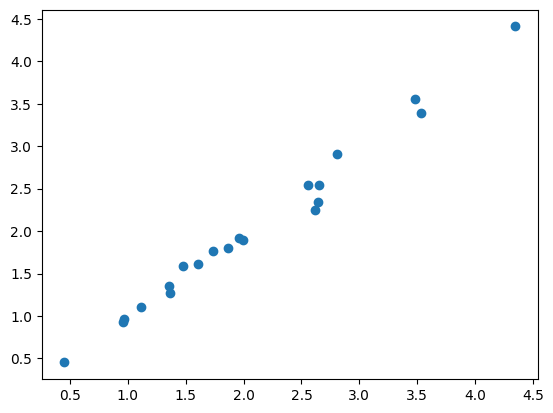

In [99]:
data_gt = np.load(f"/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/data/neurips_results/toy/gt/{data_name}.npz", allow_pickle=True)
assert (data['start_points'] == data_gt['start_points']).all() and (data['end_points'] == data_gt['end_points']).all()
# def cc_func(x0, x1, t):
#     return gbmodel.cc(x0, x1, t, ids)
# vectors = velocity(cc_func, gbmodel.ts, x0, x1)
cc_pts = gbmodel.cc(x0, x1, gbmodel.ts, ids)
# vectors_flat = vectors.flatten(0,1)
cc_pts_flat = cc_pts.flatten(0, 1)
# jac_flat = jacobian(gbmodel.func, cc_pts_flat)
# length_all = torch.sqrt((torch.einsum("nij,nj->ni", jac_flat, vectors_flat)**2).sum(axis=1))
# length_all = length_all.reshape(vectors.shape[0], vectors.shape[1])
# length = length_all.mean(axis=0)

geods = (cc_pts_flat).reshape(cc_pts.shape)
length2 = torch.sqrt(torch.diff(geods, axis=0)**2).sum(axis=-1).sum(axis=0)


# plt.scatter(length2.detach().numpy(), data_gt['geodesic_lengths'])
# plt.title(data_name)
# plt.show()

# gt_len = torch.tensor(data_gt['geodesic_lengths'])
true_geod = torch.tensor(data_gt['geodesics'], dtype=torch.float32)
gt_len = torch.sqrt(torch.diff(true_geod.permute(1,0,2), axis=0)**2).sum(axis=-1).sum(axis=0)
corr = np.corrcoef(length2.detach().cpu().numpy(), gt_len.cpu().numpy())[0,1]
mse = ((length2.detach().cpu().numpy() - gt_len.cpu().numpy())**2).mean()
dist2geod = distance_to_geodesic_criterion_len(geods.permute(1,0,2).cpu(), true_geod, lengths=gt_len).detach().numpy()

plt.scatter(length2.detach().cpu().numpy(), gt_len.cpu().numpy())
print(corr, mse, dist2geod)
res_list.append(dict(
    data_name=data_name,
    method='ours',
    corr=corr,
    mse=mse,
    dist2geod=dist2geod,
))

In [100]:
gbmodel = GeodesicBridgeOverfit(
    # func=ofm,
    func = enc_func,
    # discriminator_func=disc_func_pen,
    # discriminator_func_for_grad=discriminator_func_for_grad,
    input_dim=x.size(1), 
    hidden_dim=64, 
    scale_factor=1, 
    symmetric=True, 
    num_layers=3, 
    n_tsteps=100, 
    lr=1e-3, 
    weight_decay=1e-3,
    discriminator_weight=0.,
    discriminator_func_for_grad_weight=0.,
    id_dim=1,
    id_emb_dim=1,
    density_weight=0.,
    length_weight=1.,
)

# if cfg_main.use_wandb:
#     logger = WandbLogger()
#     checkpoint_dir = wandb.run.dir  # Use wandb's run directory for saving checkpoints

# else:
#     logger = TensorBoardLogger(save_dir=os.path.join(results_path))
#     checkpoint_dir = results_path  # Use a local directory for saving checkpoints


gbmodel.lr=1e-3
trainer = pl.Trainer(
    # logger=logger,
    max_epochs=400,
    log_every_n_steps=20,
    accelerator='cuda',
)
trainer.fit(gbmodel, dataloader)
# trainer.save_checkpoint(f"{checkpoint_dir}/gbmodel.ckpt")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params
------------------------------------------
0 | cc   | CondCurveOverfit | 42.4 K
------------------------------------------
42.4 K    Trainable params
0         Non-trainable params
42.4 K    Total params
0.169     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [101]:
# x0, x1, ids = next(iter(dataloader))
x0 = xbatch
x1 = xendbatch
ids = torch.zeros((xbatch.shape[0],1), device=x.device, dtype=x.dtype)
x0 = x0.to(device)
x1 = x1.to(device)
ids = ids.to(device)
x = x.to(device)
gbmodel = gbmodel.to(device)
with torch.no_grad():
    xhat = gbmodel(x0, x1, gbmodel.ts.to(device), ids)

xshape = xhat.shape
xflatten = xhat.flatten(0,1)
with torch.no_grad():
    zhat_flatten = model.encoder(xflatten)
    zhat = zhat_flatten.reshape(xshape[0], xshape[1], -1)
    z0 = model.encoder(x0)
    z1 = model.encoder(x1)

    fig = scatter(x.cpu().numpy(), data['colors'], s=3, white_bkgrnd=True, alpha=.2)
    fig = scatter(x0.detach().cpu().numpy(), s=10, fig=fig)
    fig = scatter(x1.detach().cpu().numpy(), s=10, fig=fig)
    fig = trajectories(xhat.detach().cpu().numpy(), s=5, fig=fig, title='No Density')
    fig.show()
# if cfg_main.use_wandb:
#     wandb.log({"geodesic": wandb.Plotly(fig)})

fig = scatter(zc, data['colors'], s=3, alpha=.2)
fig = scatter(z0.detach().cpu().numpy(), s=10, fig=fig)
fig = scatter(z1.detach().cpu().numpy(), s=10, fig=fig)
fig = trajectories(zhat.detach().cpu().numpy(), s=5, fig=fig, title='Geodesic latent')#, filename=f'{results_path}/geodesic_latent.html', white_bkgrnd=True, ticks=False)
fig.show()
# if cfg_main.use_wandb:
#     wandb.log({"geodesic_latent": wandb.Plotly(fig)})

# with torch.no_grad():
#     xconc = xhat.flatten(0, 1)
#     probs = disc_func(xconc)
# fig = scatter(xconc.cpu().numpy(), probs.cpu().numpy(), s=2, title='geodesic on-mfd probability')
# fig.show()

0.9171001943423844 0.32109824 0.04267267


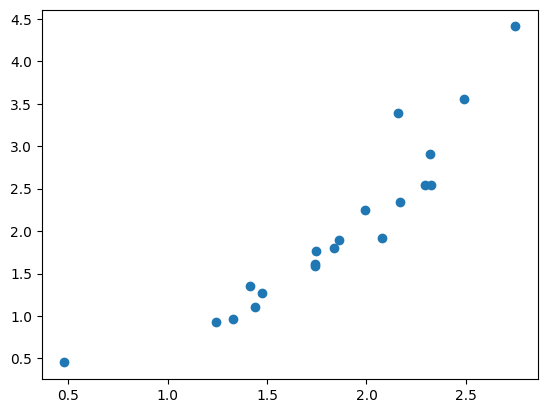

In [102]:
data_gt = np.load(f"/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/data/neurips_results/toy/gt/{data_name}.npz", allow_pickle=True)
assert (data['start_points'] == data_gt['start_points']).all() and (data['end_points'] == data_gt['end_points']).all()
# def cc_func(x0, x1, t):
#     return gbmodel.cc(x0, x1, t, ids)
# vectors = velocity(cc_func, gbmodel.ts, x0, x1)
cc_pts = gbmodel.cc(x0, x1, gbmodel.ts, ids)
# vectors_flat = vectors.flatten(0,1)
cc_pts_flat = cc_pts.flatten(0, 1)
# jac_flat = jacobian(gbmodel.func, cc_pts_flat)
# length_all = torch.sqrt((torch.einsum("nij,nj->ni", jac_flat, vectors_flat)**2).sum(axis=1))
# length_all = length_all.reshape(vectors.shape[0], vectors.shape[1])
# length = length_all.mean(axis=0)

geods = (cc_pts_flat).reshape(cc_pts.shape)
length2 = torch.sqrt(torch.diff(geods, axis=0)**2).sum(axis=-1).sum(axis=0)


# plt.scatter(length2.detach().numpy(), data_gt['geodesic_lengths'])
# plt.title(data_name)
# plt.show()

# gt_len = torch.tensor(data_gt['geodesic_lengths'])
true_geod = torch.tensor(data_gt['geodesics'], dtype=torch.float32)
gt_len = torch.sqrt(torch.diff(true_geod.permute(1,0,2), axis=0)**2).sum(axis=-1).sum(axis=0)
corr = np.corrcoef(length2.detach().cpu().numpy(), gt_len.cpu().numpy())[0,1]
mse = ((length2.detach().cpu().numpy() - gt_len.cpu().numpy())**2).mean()
dist2geod = distance_to_geodesic_criterion_len(geods.permute(1,0,2).cpu(), true_geod, lengths=gt_len).detach().numpy()

plt.scatter(length2.detach().cpu().numpy(), gt_len.cpu().numpy())
print(corr, mse, dist2geod)
res_list.append(dict(
    data_name=data_name,
    method='no density',
    corr=corr,
    mse=mse,
    dist2geod=dist2geod,
))

In [103]:
gbmodel = GeodesicBridgeOverfit(
    # func=ofm,
    func = enc_func,
    # discriminator_func=disc_func_pen,
    # discriminator_func_for_grad=discriminator_func_for_grad,
    input_dim=x.size(1), 
    hidden_dim=64, 
    scale_factor=1, 
    symmetric=True, 
    num_layers=3, 
    n_tsteps=100, 
    lr=1e-3, 
    weight_decay=1e-3,
    discriminator_weight=0.,
    discriminator_func_for_grad_weight=0.,
    id_dim=1,
    id_emb_dim=1,
    density_weight=5.,
    length_weight=1.,
    data_pts=x,
)

# if cfg_main.use_wandb:
#     logger = WandbLogger()
#     checkpoint_dir = wandb.run.dir  # Use wandb's run directory for saving checkpoints

# else:
#     logger = TensorBoardLogger(save_dir=os.path.join(results_path))
#     checkpoint_dir = results_path  # Use a local directory for saving checkpoints


gbmodel.lr=1e-3
trainer = pl.Trainer(
    # logger=logger,
    max_epochs=400,
    log_every_n_steps=20,
    accelerator='cuda',
)
trainer.fit(gbmodel, dataloader)
# trainer.save_checkpoint(f"{checkpoint_dir}/gbmodel.ckpt")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params
------------------------------------------
0 | cc   | CondCurveOverfit | 42.4 K
------------------------------------------
42.4 K    Trainable params
0         Non-trainable params
42.4 K    Total params
0.169     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [104]:
# x0, x1, ids = next(iter(dataloader))
x0 = xbatch
x1 = xendbatch
ids = torch.zeros((xbatch.shape[0],1), device=x.device, dtype=x.dtype)
x0 = x0.to(device)
x1 = x1.to(device)
ids = ids.to(device)
x = x.to(device)
gbmodel = gbmodel.to(device)
with torch.no_grad():
    xhat = gbmodel(x0, x1, gbmodel.ts.to(device), ids)

xshape = xhat.shape
xflatten = xhat.flatten(0,1)
with torch.no_grad():
    zhat_flatten = model.encoder(xflatten)
    zhat = zhat_flatten.reshape(xshape[0], xshape[1], -1)
    z0 = model.encoder(x0)
    z1 = model.encoder(x1)

    fig = scatter(x.cpu().numpy(), data['colors'], s=3, white_bkgrnd=True, alpha=.2)
    fig = scatter(x0.detach().cpu().numpy(), s=10, fig=fig)
    fig = scatter(x1.detach().cpu().numpy(), s=10, fig=fig)
    fig = trajectories(xhat.detach().cpu().numpy(), s=5, fig=fig, title='Density')
    fig.show()
# if cfg_main.use_wandb:
#     wandb.log({"geodesic": wandb.Plotly(fig)})

fig = scatter(zc, data['colors'], s=3, alpha=.2)
fig = scatter(z0.detach().cpu().numpy(), s=10, fig=fig)
fig = scatter(z1.detach().cpu().numpy(), s=10, fig=fig)
fig = trajectories(zhat.detach().cpu().numpy(), s=5, fig=fig, title='Geodesic latent')#, filename=f'{results_path}/geodesic_latent.html', white_bkgrnd=True, ticks=False)
fig.show()
# if cfg_main.use_wandb:
#     wandb.log({"geodesic_latent": wandb.Plotly(fig)})

# with torch.no_grad():
#     xconc = xhat.flatten(0, 1)
#     probs = disc_func(xconc)
# fig = scatter(xconc.cpu().numpy(), probs.cpu().numpy(), s=2, title='geodesic on-mfd probability')
# fig.show()

0.9502839466047571 0.25500798 0.014942977


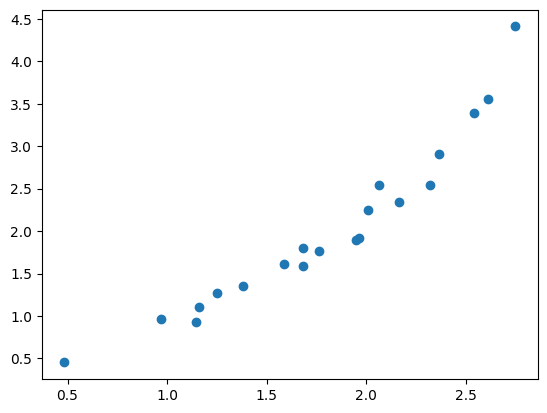

In [105]:
data_gt = np.load(f"/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/data/neurips_results/toy/gt/{data_name}.npz", allow_pickle=True)
assert (data['start_points'] == data_gt['start_points']).all() and (data['end_points'] == data_gt['end_points']).all()
# def cc_func(x0, x1, t):
#     return gbmodel.cc(x0, x1, t, ids)
# vectors = velocity(cc_func, gbmodel.ts, x0, x1)
cc_pts = gbmodel.cc(x0, x1, gbmodel.ts, ids)
# vectors_flat = vectors.flatten(0,1)
cc_pts_flat = cc_pts.flatten(0, 1)
# jac_flat = jacobian(gbmodel.func, cc_pts_flat)
# length_all = torch.sqrt((torch.einsum("nij,nj->ni", jac_flat, vectors_flat)**2).sum(axis=1))
# length_all = length_all.reshape(vectors.shape[0], vectors.shape[1])
# length = length_all.mean(axis=0)

geods = (cc_pts_flat).reshape(cc_pts.shape)
length2 = torch.sqrt(torch.diff(geods, axis=0)**2).sum(axis=-1).sum(axis=0)


# plt.scatter(length2.detach().numpy(), data_gt['geodesic_lengths'])
# plt.title(data_name)
# plt.show()

# gt_len = torch.tensor(data_gt['geodesic_lengths'])
true_geod = torch.tensor(data_gt['geodesics'], dtype=torch.float32)
gt_len = torch.sqrt(torch.diff(true_geod.permute(1,0,2), axis=0)**2).sum(axis=-1).sum(axis=0)
corr = np.corrcoef(length2.detach().cpu().numpy(), gt_len.cpu().numpy())[0,1]
mse = ((length2.detach().cpu().numpy() - gt_len.cpu().numpy())**2).mean()
dist2geod = distance_to_geodesic_criterion_len(geods.permute(1,0,2).cpu(), true_geod, lengths=gt_len).detach().numpy()

plt.scatter(length2.detach().cpu().numpy(), gt_len.cpu().numpy())
print(corr, mse, dist2geod)
res_list.append(dict(
    data_name=data_name,
    method='density',
    corr=corr,
    mse=mse,
    dist2geod=dist2geod,
))

In [106]:
pd.DataFrame(res_list)

data_name      method      corr       mse    dist2geod
0  hemisphere_none_0        ours  0.992562  0.015918  0.006343228
1  hemisphere_none_0  no density  0.917100  0.321098   0.04267267
2  hemisphere_none_0     density  0.950284  0.255008  0.014942977